In [19]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

def print_messages(messages, truncate_length=200):
    """
    Print messages with truncation for long tool message content.
    
    Args:
        messages: List of LangChain messages to print
        truncate_length: Maximum length before truncating tool message content
    """
    for message in messages:
        if isinstance(message, ToolMessage):
            print(f"=================================[1m Tool Message [0m=================================")
            print(f"Name: {message.name}\n")
            
            # Truncate long content
            content = message.content
            if len(content) > truncate_length:
                print(f"{content[:truncate_length]}...\n[Content truncated - {len(content)} chars total]")
            else:
                print(content)
        else:
            # Use pretty_print for AI and Human messages
            message.pretty_print()

### research_agent

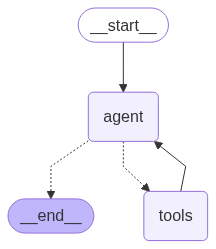

In [20]:
from typing import List, Dict
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.types import interrupt


research_system_message = """
You are a Research Agent specializing in identifying one promising company for potential investment based on the user’s request.

Responsibilities:
- Interpret the user’s theme or sector (e.g., AI, renewable energy, EVs) and propose ONE company that best fits.
- Use the available tools to discover, verify, and cross-check information.
- Prefer recent, credible information and avoid speculation.

Behavior:
- Do NOT place or simulate trades. Your job ends at recommending a company.
- Keep research tight (aim for 2–3 tool calls); refine queries if results are noisy.
- Ask a brief clarifying question only if the request is too vague to proceed.
- Do not fabricate numbers or facts. Be concise, neutral, and risk-aware.
- Consider the current date when discussing recency or momentum.

Outputs:
- 1–2 sentences explaining why the company fits the request (clear, plain language).
- Final line: CHOSEN_COMPANY: <Company Name>
"""

FORBIDDEN_KEYWORDS = {
    "403 forbidden", "access denied", "captcha",
    "has been denied", "not authorized", "verify you are a human"
}

@tool
def web_search(query: str, max_results: int = 5) -> Dict[str, List[Dict[str, str]]]:
    """
    General-purpose web search.

    Use when you need recent or broader information from the web to answer the user's request
    (e.g., discover relevant entities, find supporting context, or gather up-to-date references).

    Parameters:
    - query (str): The search query in plain language.
    - max_results (int): Number of results to return (default 5, max 10).

    Returns:
    - {"results": [{"title": str, "url": str, "snippet": str}, ...]}

    Example:
    - query: "emerging AI hardware companies"
    """
    max_results = max(1, min(max_results, 10))
    tavily = TavilySearch(max_results=max_results)
    raw = tavily.invoke({"query": query})

    results = [
        {k: v for k, v in page.items() if k != "raw_content"}  # drop heavy field
        for page in raw["results"]
        if not any(
            k in ((page.get("content") or "").lower())
            for k in FORBIDDEN_KEYWORDS
        )
    ]

    return {"results": results}


from langchain_community.document_loaders import WikipediaLoader

@tool
def wiki_search(topic: str, max_results: int = 5) -> dict:
    """
    Fetch a concise encyclopedic summary for a single entity or topic.

    When to use:
      - You need neutral background about a company, product, person, or concept.

    How to format `topic` (VERY IMPORTANT):
      - Pass a short, Wikipedia-friendly title or entity name.
      - Avoid questions or long queries. Prefer canonical forms.
      - If you have noisy text, reduce it to the key noun phrase.

    Good examples:
      - "NVIDIA", "OpenAI", "Large language model", "Electric vehicle"
    Avoid:
      - "What is NVIDIA and why is it important?", "tell me about AI chips 2025"

    Parameters:
      - topic (str): Canonical page title or concise entity/topic.
    """
    max_results = max(1, min(max_results, 10))
    wiki = WikipediaLoader(query=topic, load_max_docs=max_results)
    raw = wiki.load()

    results = [
      {
        "title": doc.metadata["title"],
        "summary": doc.metadata["summary"],
        "source": doc.metadata["source"]
      }
      for doc in raw
    ]

    return {"results": results}


research_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[web_search, wiki_search],
    prompt=research_system_message,

    name="research_agent"
)

display(Image(research_agent.get_graph().draw_mermaid_png()))

### trading_agent

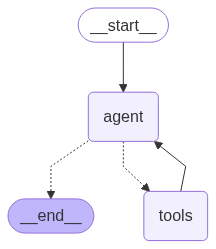

In [21]:
import requests
import yfinance as yf
from pprint import pformat
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
from IPython.display import Image, display
from langgraph.types import interrupt

@tool("lookup_stock")
def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "your_alphavantage_api_key"
    }
    
    response = requests.get(api_url, params=params)
    data = response.json()
    
    if "bestMatches" in data and data["bestMatches"]:
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


@tool("fetch_stock_data")
def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }

        return pformat(combined_data)

    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}

trading_system_message = """
You are a financial advisor assistant. Use the provided tools to ground your answers
in up-to-date market data. Be concise, factual, and risk-aware.

Be decisive: when you have sufficient information to act, proceed with tool calls without
asking for confirmation. Only if information is missing or uncertain, ask a concise 
clarifying question.

When preparing or describing actions, include appropriate parameters (e.g., symbol, shares,
limit price, budgets) based on available data. Do not fabricate numbers or facts.
"""

@tool
def place_order(
    symbol: str,
    action: str,
    shares: int,
    limit_price: float,
    order_type: str = "limit",
) -> dict:
    """
    Execute a stock order.

    Parameters:
    - symbol: Ticker
    - action: "buy" or "sell"
    - shares: Number of shares to trade (pre-computed by the agent)
    - limit_price: Limit price per share
    - order_type: Order type, default "limit"

    Returns:
    - status: Execution result (simulated)
    - symbol
    - shares
    - limit_price
    - total_spent
    - type: Order type used
    - action
    """
    total_spent = round(int(shares) * limit_price, 2)
    return {
        "status": "filled",
        "symbol": symbol,
        "shares": int(shares),
        "limit_price": limit_price,
        "total_spent": total_spent,
        "type": order_type,
        "action": action,
    }

trading_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[lookup_stock_symbol, fetch_stock_data_raw, place_order],
    prompt=trading_system_message,
    version="v2",


    name="trading_agent"
)

display(Image(trading_agent.get_graph().draw_mermaid_png()))

### supervisor with checkpointer

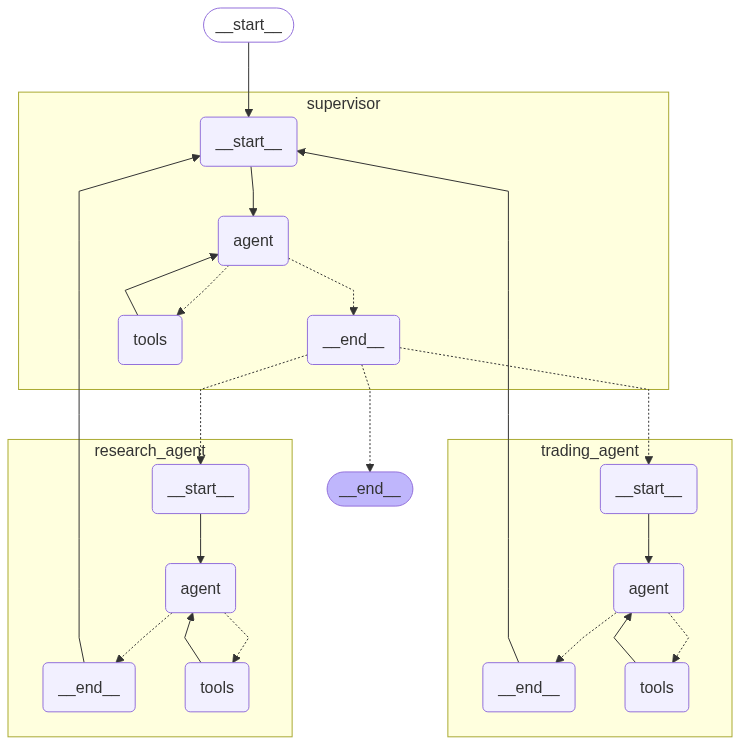

In [22]:
from IPython.display import Image, display
from langgraph_supervisor import create_supervisor
from langchain_openai import ChatOpenAI
from datetime import datetime
from langchain_core.tools import tool
from langgraph.checkpoint.memory import InMemorySaver

@tool
def current_timestamp() -> dict:
    """
    Return the current local timestamp.

    Returns:
    - {"iso": str, "epoch": int, "tz": str}
      where:
      - iso: ISO 8601 string with timezone offset
      - epoch: Unix epoch seconds
      - tz: timezone name/offset
    """
    now = datetime.now().astimezone()
    return {
        "iso": now.isoformat(),
        "epoch": int(now.timestamp()),
        "tz": str(now.tzinfo),
    }

supervisor_system_message = """
You are a Supervisor coordinating two specialists:

- research_agent: finds ONE suitable company matching the user’s request and explains why.
- trading_agent: given a company and a budget/action, determines the ticker, checks market data, sizes the order, and places a trade.

Your goal is to satisfy the user’s intent with minimal steps.

Clocking / Context:
- If the conversation does not already contain a “NOW” context, first obtain it by calling the tool `current_timestamp`.
- After obtaining it, post a single one-line note into the thread so it’s available to all subsequent steps, e.g.:
  "System context — NOW: {iso} ({tz}); epoch={epoch}"
- Use this “NOW” as the reference for recency. Do not call `current_timestamp` again unless the prior “NOW” is missing or clearly stale.


Routing:
- If the request is thematic or ambiguous, ask research_agent.
- If the request already names a company and includes an action/budget, use trading_agent.
- If a single key detail is missing (e.g., budget), ask once, then proceed.

Handoff:
- From research_agent expect: one company name + 1–2 sentence rationale.
- Pass that company (and any provided budget/action) to trading_agent.

Guardrails:
- Don’t invent data. Don’t place trades without explicit user budget/action.
- Prefer the current date context when judging recency.

Output:
- Briefly state what you delegated and the result. If blocked, ask only for what’s needed to proceed.
"""

supervisor = create_supervisor(
    agents=[research_agent, trading_agent],
    tools=[current_timestamp],
    model=ChatOpenAI(model="gpt-4o-mini"),
    prompt=supervisor_system_message,
    
    output_mode="full_history"
).compile()

display(Image(supervisor.get_graph(xray=1).draw_mermaid_png()))

### run it

In [23]:
from langchain_core.messages import HumanMessage
import uuid

config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "user_id": "evgeny"
    }
}

response = supervisor.invoke({"messages": [
    HumanMessage(content="""
    I want you to invest $1,000 into the most promising company in the AI sector.  
    Please research the options, pick the best candidate, and then go ahead and place a buy order for me.
    """)
]}, config)

print_messages(response['messages'])

================================ Human Message =================================


    I want you to invest $1,000 into the most promising company in the AI sector.  
    Please research the options, pick the best candidate, and then go ahead and place a buy order for me.
    
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  current_timestamp (call_Ype0ponvga8L1r4NoJ9EdceQ)
 Call ID: call_Ype0ponvga8L1r4NoJ9EdceQ
  Args:
================================= Tool Message =================================
Name: current_timestamp

{"iso": "2025-09-12T11:55:57.759518+02:00", "epoch": 1757670957, "tz": "CEST"}
================================== Ai Message ==================================
Name: supervisor

System context — NOW: 2025-09-12T11:55:57.759518+02:00 (CEST); epoch=1757670957

I will first research the most promising company in the AI sector. Please hold on.
Tool Calls:
  transfer_to_research_agent (call_Nxs5Hhp1dE3j6ROFQ

## Supervisor with tools

In [24]:
from typing import Annotated

from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import InjectedState
from langchain_core.messages import AIMessage

def final_ai_text(response: dict) -> str:
    msgs = response.get("messages", [])
    for m in reversed(msgs):
        if isinstance(m, AIMessage) and m.content and m.content.strip():
            return m.content
    return ""


@tool
def research_agent_tool(
    task: str,
    state: Annotated[dict, InjectedState],
    config: RunnableConfig, 
):
    """
    Execute a company research task for investment idea generation.

    Purpose:
    - Identify exactly one publicly tradable company that best fits the provided theme/sector request.

    Capabilities:
    - Uses web search to discover and verify recent, credible information.
    - Uses Wikipedia summaries for neutral background on entities.
    - Operates concisely and factually; avoids speculation and trade execution.

    Inputs:
    - task: A clear research objective (e.g., “find a leading AI hardware company”).

    Output:
    - 1–2 sentence rationale followed by: `CHOSEN_COMPANY: <Company Name>`
    """
    config = config
    # we still can reuse her "state" properties if needed (included all the previous meesages)
    response = research_agent.invoke(
        {"messages": [HumanMessage(content=task)]},
        config=config
    )
    return final_ai_text(response)


@tool
def trading_agent_tool(
    task: str,
    state: Annotated[dict, InjectedState],
    config: RunnableConfig, 
):
    """
    Execute a trading task using market data and order placement tools.

    Purpose:
    - Interpret a trading instruction (e.g., buy/sell a specific company or symbol).
    - Determine or verify the stock symbol, retrieve recent market data, and, when appropriate, place an order.

    Capabilities:
    - Symbol resolution via `lookup_stock_symbol` (company → ticker).
    - Market data retrieval via `fetch_stock_data_raw` (recent info and history).
    - Order execution via `place_order` (simulated fill with parameters provided or inferred).

    Input:
    - task: A concrete trading objective (e.g., “buy 5 shares of Tesla at $250 limit” or “evaluate and buy a leading EV stock within $1,000 budget”).

    Output:
    - A concise, factual response that may include symbol, shares, limit price, total cost, and execution status.
    """
    config = config
    # we still can reuse her "state" properties if needed (included all the previous meesages)
    response = trading_agent.invoke(
        {"messages": [HumanMessage(content=task)]},
        config=config
    )
    return final_ai_text(response)

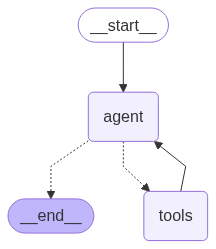

In [25]:
from IPython.display import Image, display
from datetime import datetime
from langchain_core.tools import tool

@tool
def current_timestamp() -> dict:
    """
    Return the current local timestamp.

    Returns:
    - {"iso": str, "epoch": int, "tz": str}
      where:
      - iso: ISO 8601 string with timezone offset
      - epoch: Unix epoch seconds
      - tz: timezone name/offset
    """
    now = datetime.now().astimezone()
    return {
        "iso": now.isoformat(),
        "epoch": int(now.timestamp()),
        "tz": str(now.tzinfo),
    }

supervisor_system_message = """
You are a Supervisor coordinating two specialists:

- research_agent: finds ONE suitable company matching the user’s request and explains why.
- trading_agent: given a company and a budget/action, determines the ticker, checks market data, sizes the order, and places a trade.

Your goal is to satisfy the user’s intent with minimal steps.

Clocking / Context:
- If the conversation does not already contain a “NOW” context, first obtain it by calling the tool `current_timestamp`.
- After obtaining it, post a single one-line note into the thread so it’s available to all subsequent steps, e.g.:
  "System context — NOW: {iso} ({tz}); epoch={epoch}"
- Use this “NOW” as the reference for recency. Do not call `current_timestamp` again unless the prior “NOW” is missing or clearly stale.


Routing:
- If the request is thematic or ambiguous, ask research_agent.
- If the request already names a company and includes an action/budget, use trading_agent.
- If a single key detail is missing (e.g., budget), ask once, then proceed.

Handoff:
- From research_agent expect: one company name + 1–2 sentence rationale.
- Pass that company (and any provided budget/action) to trading_agent.

Guardrails:
- Don’t invent data. Don’t place trades without explicit user budget/action.
- Prefer the current date context when judging recency.

Output:
- Briefly state what you delegated and the result. If blocked, ask only for what’s needed to proceed.
"""


supervisor = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[current_timestamp, research_agent_tool, trading_agent_tool],
    prompt=supervisor_system_message,
    version="v2",
    name="supervisor"
)

display(Image(supervisor.get_graph().draw_mermaid_png()))

### run it

In [26]:
from langchain_core.messages import HumanMessage
import uuid

config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "user_id": "evgeny"
    }
}

response = supervisor.invoke({"messages": [
    HumanMessage(content="""I want you to invest $1,000 into the most promising company in the AI sector.  
    Please research the options, pick the best candidate, and then go ahead and place a buy order for me.
    """)
]}, config)

for m in response['messages']:
    m.pretty_print()

HTTP Error 404: 
$MSF0.FRK: possibly delisted; no price data found  (period=1mo) (Yahoo error = "No data found, symbol may be delisted")
HTTP Error 404: 
$MSF.DEX: possibly delisted; no price data found  (period=1mo) (Yahoo error = "No data found, symbol may be delisted")


================================ Human Message =================================

I want you to invest $1,000 into the most promising company in the AI sector.  
    Please research the options, pick the best candidate, and then go ahead and place a buy order for me.
    
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  current_timestamp (call_QSsW1J1mRZGsHumk9PHkRF89)
 Call ID: call_QSsW1J1mRZGsHumk9PHkRF89
  Args:
================================= Tool Message =================================
Name: current_timestamp

{"iso": "2025-09-12T12:02:53.112495+02:00", "epoch": 1757671373, "tz": "CEST"}
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  research_agent_tool (call_qDAgdffWSF80N1YxPaiysOLD)
 Call ID: call_qDAgdffWSF80N1YxPaiysOLD
  Args:
    task: find a leading AI company for investment
================================= Tool Message ======================